
1.   model: unet

1-1 CelebAMask 이미지 라벨만들기


In [1]:
import os
import cv2
import numpy as np
from glob import glob
from tqdm import tqdm

In [2]:
label_list = ['skin', 'nose', 'eye_g', 'l_eye', 'r_eye', 'l_brow', 'r_brow', 'l_ear', 'r_ear', 'mouth', 'u_lip', 'l_lip', 'hair', 'hat', 'ear_r', 'neck_l', 'neck', 'cloth']

folder_base = './CelebAdataset/CelebAMask-HQ/CelebAMask-HQ-mask-anno'
folder_save = './CelebAdataset/CelebAMask-HQ/CelebAMask_label'
img_num = 30000

for k in tqdm(range(img_num)):
    folder_num = k // 2000
    im_base = np.zeros((512, 512))
    for idx, label in enumerate(label_list):
        filename = f"{folder_base}/{folder_num}/{k:0>5}_{label}.png"
        if (os.path.exists(filename)):
            im = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
            im_base[im != 0] = (idx + 1)

    filename_save = f"{folder_save}/{k}.png"
    cv2.imwrite(filename_save, im_base)

100%|██████████| 30000/30000 [11:50<00:00, 42.24it/s]


1-1-1 mask를 train valid 로 나누기

In [2]:
for path in glob('./CelebAdataset/*'):
    print(len(glob(path+'/*')))

9


In [3]:
all_mask = glob('./CelebAdataset/CelebAMask-HQ/CelebAMask_label/*')
print(len(all_mask))

30000


In [4]:
import random
random.shuffle(all_mask)

In [5]:
cnt = int(len(all_mask)*0.9)
train = all_mask[:cnt]
valid = all_mask[cnt:]
print(len(train))
print(len(valid))

27000
3000


In [10]:
import shutil
for path in tqdm(train):
    shutil.copy(path, path.replace('./CelebAdataset/CelebAMask-HQ/CelebAMask_label', './CelebAdataset/CelebAMask-HQ/train_mask'))

100%|██████████| 27000/27000 [00:01<00:00, 25374.92it/s]


In [12]:
import shutil
for path in tqdm(valid):
    shutil.copy(path, path.replace('./CelebAdataset/CelebAMask-HQ/CelebAMask_label', './CelebAdataset/CelebAMask-HQ/valid_mask'))

100%|██████████| 3000/3000 [00:00<00:00, 24830.95it/s]


1-2 image dataset/loader 정의

In [6]:
import os
import copy
from glob import glob
from tqdm import tqdm

import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
from torch import optim
from torch.optim import lr_scheduler
from torchvision import transforms

In [7]:
import numpy as np

In [8]:
class CelebAMaskDataset():
    def __init__(self, img_path, label_path, transform_img, transform_label):
        self.img_path = img_path
        self.label_path = label_path
        self.transform_img = transform_img
        self.transform_label = transform_label
        self.dataset = glob(f'{label_path}/*')

    def __getitem__(self, index):
        label_path = self.dataset[index] 
        img_path = label_path.replace(self.label_path, self.img_path).replace('png', 'jpg')
        image = Image.open(img_path)
        label = Image.open(label_path)
        img, la = self.transform_img(image), self.transform_label(label)

        return img, la

    def __len__(self):
        """Return the number of images."""
        return len(self.dataset)

In [9]:
transform_Image = transforms.Compose([
        transforms.Resize(512),
        transforms.ToTensor()
    ])
transform_Label = transforms.Compose([
        transforms.Resize(512),
        transforms.ToTensor()
    ])

In [10]:
train_dataset = CelebAMaskDataset('./CelebAdataset/CelebAMask-HQ/CelebA-HQ-img', './CelebAdataset/CelebAMask-HQ/train_mask', transform_Image, transform_Label)
valid_dataset = CelebAMaskDataset('./CelebAdataset/CelebAMask-HQ/CelebA-HQ-img', './CelebAdataset/CelebAMask-HQ/valid_mask', transform_Image, transform_Label)

In [11]:
train_dataloaders = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=8)
valid_dataloaders = torch.utils.data.DataLoader(valid_dataset, batch_size=16, shuffle=False, num_workers=8)

input image


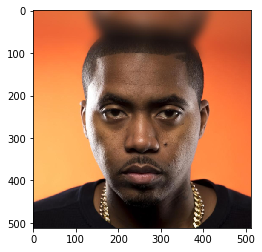

mask image


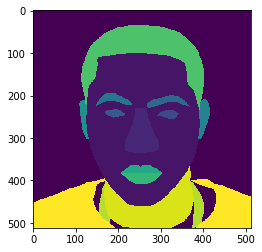

In [12]:
dataset = iter(train_dataset)
img, label = next(dataset)
img, label = img.numpy().transpose((1, 2, 0)), label.numpy().transpose((1, 2, 0))

print('input image')
plt.imshow(np.int32(img*255))
plt.show()

print('mask image')
plt.imshow(np.int32(label*255).reshape(512,512))
plt.show()

1-3 model 정의

In [13]:
def conv3x3(in_channels, out_channels, kernel_size=3, stride=1, padding=1):
    conv = nn.Sequential(nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding),
                         nn.BatchNorm2d(out_channels),
                         nn.ReLU())
    return conv

In [14]:
class Unet(nn.Module):
    def __init__(self, num_class=1):
        super(Unet, self).__init__()

        ## encoder
        self.down1_1  = conv3x3(in_channels=3, out_channels=64)
        self.down1_2 = conv3x3(in_channels=64, out_channels=64)
        self.downpool1 = nn.MaxPool2d(kernel_size=2)

        self.down2_1 = conv3x3(in_channels=64, out_channels=128)
        self.down2_2 = conv3x3(in_channels=128, out_channels=128)
        self.downpool2 = nn.MaxPool2d(kernel_size=2)

        self.down3_1 = conv3x3(in_channels=128, out_channels=256)
        self.down3_2 = conv3x3(in_channels=256, out_channels=256)
        self.downpool3 = nn.MaxPool2d(kernel_size=2)

        self.down4_1 = conv3x3(in_channels=256, out_channels=512)
        self.down4_2 = conv3x3(in_channels=512, out_channels=512)
        self.downpool4 = nn.MaxPool2d(kernel_size=2)

        self.down5_1 = conv3x3(in_channels=512, out_channels=1024)

        ## decoder
        self.up5_1 = conv3x3(in_channels=1024, out_channels=512)

        self.uppool4 = nn.ConvTranspose2d(in_channels=512, out_channels=512,
                                          kernel_size=2, stride=2, padding=0, bias=True)
        self.up4_2 = conv3x3(in_channels=2 * 512, out_channels=512)
        self.up4_1 = conv3x3(in_channels=512, out_channels=256)

        self.uppool3 = nn.ConvTranspose2d(in_channels=256, out_channels=256,
                                          kernel_size=2, stride=2, padding=0, bias=True)        
        self.up3_2 = conv3x3(in_channels=2 * 256, out_channels=256)
        self.up3_1 = conv3x3(in_channels=256, out_channels=128)


        self.uppool2 = nn.ConvTranspose2d(in_channels=128, out_channels=128,
                                          kernel_size=2, stride=2, padding=0, bias=True)        
        self.up2_2 = conv3x3(in_channels=2 * 128, out_channels=128)
        self.up2_1 = conv3x3(in_channels=128, out_channels=64)

        self.uppool1 = nn.ConvTranspose2d(in_channels=64, out_channels=64,
                                          kernel_size=2, stride=2, padding=0, bias=True)        
        self.up1_2 = conv3x3(in_channels=2 * 64, out_channels=64)
        self.up1_1 = conv3x3(in_channels=64, out_channels=64)

        self.fc = nn.Conv2d(in_channels=64, out_channels=num_class, kernel_size=1, stride=1, padding=0)

    def forward(self, x):
        down1_1 = self.down1_1(x)
        down1_2 = self.down1_2(down1_1)
        downppool1 = self.downpool1(down1_2)

        down2_1 = self.down2_1(downppool1)
        down2_2 = self.down2_2(down2_1)
        downppool2 = self.downpool2(down2_2)

        down3_1 = self.down3_1(downppool2)
        down3_2 = self.down3_2(down3_1)
        downpool3 = self.downpool3(down3_2)

        down4_1 = self.down4_1(downpool3)
        down4_2 = self.down4_2(down4_1)
        downpool4 = self.downpool4(down4_2)

        down5_1 = self.down5_1(downpool4)

        ## decoder
        up5_1 = self.up5_1(down5_1)

        uppool4 = self.uppool4(up5_1)
        cat4 = torch.cat((uppool4, down4_2), dim=1)
        up4_2 = self.up4_2(cat4)
        up4_1 = self.up4_1(up4_2)

        uppool3 = self.uppool3(up4_1)
        cat3 = torch.cat((uppool3, down3_2), dim=1)
        up3_2 = self.up3_2(cat3)
        up3_1 = self.up3_1(up3_2)

        unpool2 = self.uppool2(up3_1)
        cat2 = torch.cat((unpool2, down2_2), dim=1)
        up2_2 = self.up2_2(cat2)
        up2_1 = self.up2_1(up2_2)

        unpool1 = self.uppool1(up2_1)
        cat1 = torch.cat((unpool1, down1_2), dim=1)
        up1_2 = self.up1_2(cat1)
        up1_1 = self.up1_1(up1_2)

        logit = self.fc(up1_1)
        return logit

In [15]:
import segmentation_models_pytorch as smp

In [16]:
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = smp.Unet(classes=19)
# model = Unet(19)
model.to(device)

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [17]:
import torch.nn.functional as F
def cross_entropy2d(input, target, weight=None, size_average=True):
    n, c, h, w = input.size()  
    nt, ht, wt = target.size()  

    if h != ht or w != wt:
        input = F.interpolate(input, size=(ht, wt), mode="bilinear", align_corners=True)  

    input = input.transpose(1, 2).transpose(2, 3).contiguous().view(-1, c) 
    target = target.view(-1)
    loss = F.cross_entropy(input, target)
    return loss

In [18]:
criterion = cross_entropy2d
optimizer = optim.Adam(model.parameters(), 0.0002, [.5, .999])
scheduler=None
num_epochs=50

In [19]:
def generate_label_plain(inputs, imsize=512):
    pred_batch = []
    for input in inputs:
        input = input.view(1, 19, imsize, imsize)
        pred = np.squeeze(input.data.max(1)[1].cpu().numpy(), axis=0)
        pred_batch.append(pred)

    pred_batch = np.array(pred_batch)
    pred_batch = torch.from_numpy(pred_batch)
            
    label_batch = []
    for p in pred_batch:
        label_batch.append(p.numpy())
                
    label_batch = np.array(label_batch)

    return label_batch

 Epoch[1/50] train : runing_Loss 0.33042: 100%|██████████| 1688/1688 [14:20<00:00,  1.96it/s]
 Epoch[1/50] valid : valid_acc 0.1742429843346278 valid_iou 0.7181967496871948: 100%|██████████| 188/188 [00:42<00:00,  4.41it/s] 


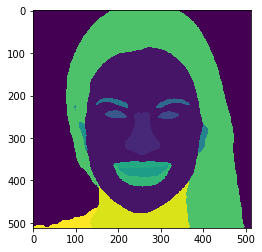

  0%|          | 0/1688 [00:00<?, ?it/s]

---------- best epoch : 0 ----------


 Epoch[2/50] train : runing_Loss 0.16279: 100%|██████████| 1688/1688 [14:25<00:00,  1.95it/s]
 Epoch[2/50] valid : valid_acc 0.15673656050364176 valid_iou 0.7169828414916992: 100%|██████████| 188/188 [00:41<00:00,  4.51it/s]


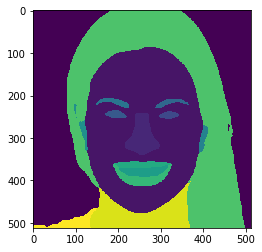

  0%|          | 0/1688 [00:00<?, ?it/s]

---------- best epoch : 0 ----------


 Epoch[3/50] train : runing_Loss 0.14421: 100%|██████████| 1688/1688 [14:25<00:00,  1.95it/s]
 Epoch[3/50] valid : valid_acc 0.16228235876560212 valid_iou 0.7203205227851868: 100%|██████████| 188/188 [00:42<00:00,  4.41it/s]


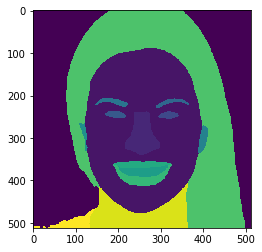

  0%|          | 0/1688 [00:00<?, ?it/s]

---------- best epoch : 2 ----------


 Epoch[4/50] train : runing_Loss 0.13457: 100%|██████████| 1688/1688 [14:26<00:00,  1.95it/s]
 Epoch[4/50] valid : valid_acc 0.1530415474176407 valid_iou 0.7166699767112732: 100%|██████████| 188/188 [00:42<00:00,  4.41it/s] 


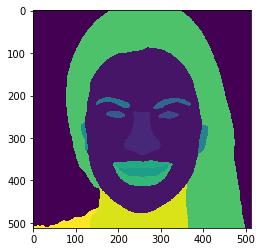

  0%|          | 0/1688 [00:00<?, ?it/s]

---------- best epoch : 2 ----------


 Epoch[5/50] train : runing_Loss 0.12636: 100%|██████████| 1688/1688 [14:26<00:00,  1.95it/s]
 Epoch[5/50] valid : valid_acc 0.1453771087328593 valid_iou 0.7196577787399292: 100%|██████████| 188/188 [00:41<00:00,  4.52it/s] 


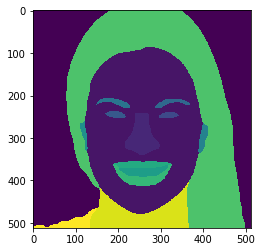

  0%|          | 0/1688 [00:00<?, ?it/s]

---------- best epoch : 2 ----------


 Epoch[6/50] train : runing_Loss 0.11893: 100%|██████████| 1688/1688 [14:26<00:00,  1.95it/s]
 Epoch[6/50] valid : valid_acc 0.1507354516585668 valid_iou 0.7200877070426941: 100%|██████████| 188/188 [00:42<00:00,  4.41it/s] 


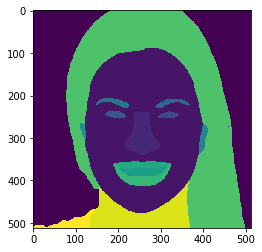

  0%|          | 0/1688 [00:00<?, ?it/s]

---------- best epoch : 2 ----------


 Epoch[7/50] train : runing_Loss 0.11424: 100%|██████████| 1688/1688 [14:26<00:00,  1.95it/s]
 Epoch[7/50] valid : valid_acc 0.13891245768467586 valid_iou 0.7192874550819397: 100%|██████████| 188/188 [00:42<00:00,  4.41it/s]


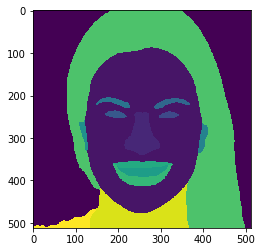

  0%|          | 0/1688 [00:00<?, ?it/s]

---------- best epoch : 2 ----------


 Epoch[8/50] train : runing_Loss 0.10927: 100%|██████████| 1688/1688 [14:26<00:00,  1.95it/s]
 Epoch[8/50] valid : valid_acc 0.13833281966050465 valid_iou 0.7188593745231628: 100%|██████████| 188/188 [00:41<00:00,  4.51it/s]


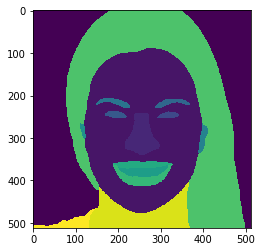

  0%|          | 0/1688 [00:00<?, ?it/s]

---------- best epoch : 2 ----------


 Epoch[9/50] train : runing_Loss 0.10500: 100%|██████████| 1688/1688 [14:28<00:00,  1.94it/s]
 Epoch[9/50] valid : valid_acc 0.15207044889529547 valid_iou 0.7193900346755981: 100%|██████████| 188/188 [00:42<00:00,  4.41it/s]


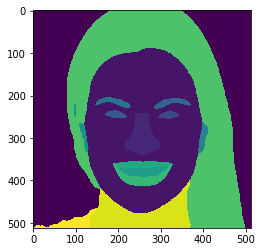

  0%|          | 0/1688 [00:00<?, ?it/s]

---------- best epoch : 2 ----------


 Epoch[10/50] train : runing_Loss 0.10059: 100%|██████████| 1688/1688 [14:27<00:00,  1.94it/s]
 Epoch[10/50] valid : valid_acc 0.15915362866719565 valid_iou 0.7188453078269958: 100%|██████████| 188/188 [00:42<00:00,  4.41it/s]


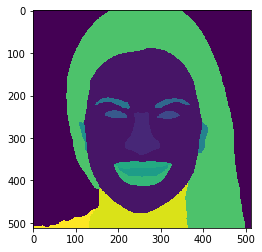

  0%|          | 0/1688 [00:00<?, ?it/s]

---------- best epoch : 2 ----------


 Epoch[11/50] train : runing_Loss 0.09771: 100%|██████████| 1688/1688 [14:27<00:00,  1.95it/s]
 Epoch[11/50] valid : valid_acc 0.14559814647833505 valid_iou 0.7188177704811096: 100%|██████████| 188/188 [00:41<00:00,  4.51it/s]


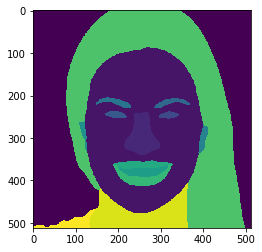

  0%|          | 0/1688 [00:00<?, ?it/s]

---------- best epoch : 2 ----------


 Epoch[12/50] train : runing_Loss 0.09331: 100%|██████████| 1688/1688 [14:26<00:00,  1.95it/s]
 Epoch[12/50] valid : valid_acc 0.14670129803816478 valid_iou 0.7195659279823303: 100%|██████████| 188/188 [00:42<00:00,  4.41it/s]


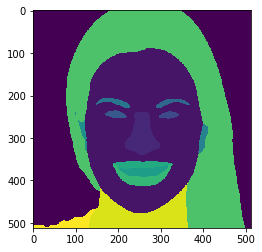

  0%|          | 0/1688 [00:00<?, ?it/s]

---------- best epoch : 2 ----------


 Epoch[13/50] train : runing_Loss 0.09070: 100%|██████████| 1688/1688 [14:26<00:00,  1.95it/s]
 Epoch[13/50] valid : valid_acc 0.14740616619586944 valid_iou 0.7193505764007568: 100%|██████████| 188/188 [00:42<00:00,  4.41it/s]


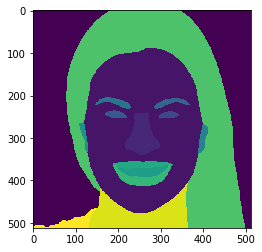

  0%|          | 0/1688 [00:00<?, ?it/s]

---------- best epoch : 2 ----------


 Epoch[14/50] train : runing_Loss 0.08668: 100%|██████████| 1688/1688 [14:25<00:00,  1.95it/s]
 Epoch[14/50] valid : valid_acc 0.14776351078351338 valid_iou 0.7182826399803162: 100%|██████████| 188/188 [00:42<00:00,  4.47it/s]


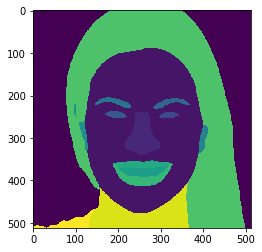

  0%|          | 0/1688 [00:00<?, ?it/s]

---------- best epoch : 2 ----------


 Epoch[15/50] train : runing_Loss 0.08417: 100%|██████████| 1688/1688 [14:25<00:00,  1.95it/s]
 Epoch[15/50] valid : valid_acc 0.15410864317417144 valid_iou 0.7176201343536377: 100%|██████████| 188/188 [00:42<00:00,  4.46it/s]


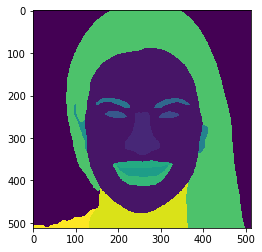

  0%|          | 0/1688 [00:00<?, ?it/s]

---------- best epoch : 2 ----------


 Epoch[16/50] train : runing_Loss 0.08193: 100%|██████████| 1688/1688 [14:25<00:00,  1.95it/s]
 Epoch[16/50] valid : valid_acc 0.1540020045042038 valid_iou 0.7187277674674988: 100%|██████████| 188/188 [00:42<00:00,  4.47it/s] 


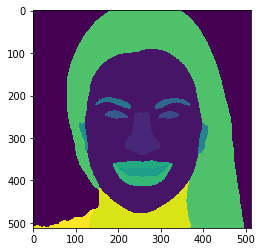

  0%|          | 0/1688 [00:00<?, ?it/s]

---------- best epoch : 2 ----------


 Epoch[17/50] train : runing_Loss 0.08170: 100%|██████████| 1688/1688 [14:25<00:00,  1.95it/s]
 Epoch[17/50] valid : valid_acc 0.15687626218795778 valid_iou 0.7185266613960266: 100%|██████████| 188/188 [00:42<00:00,  4.47it/s]


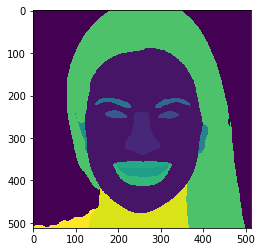

  0%|          | 0/1688 [00:00<?, ?it/s]

---------- best epoch : 2 ----------


 Epoch[18/50] train : runing_Loss 0.07701: 100%|██████████| 1688/1688 [14:25<00:00,  1.95it/s]
 Epoch[18/50] valid : valid_acc 0.15629645895957947 valid_iou 0.7180529832839966: 100%|██████████| 188/188 [00:42<00:00,  4.46it/s]


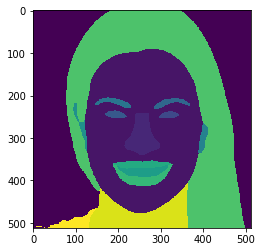

  0%|          | 0/1688 [00:00<?, ?it/s]

---------- best epoch : 2 ----------


 Epoch[19/50] train : runing_Loss 0.07497: 100%|██████████| 1688/1688 [14:25<00:00,  1.95it/s]
 Epoch[19/50] valid : valid_acc 0.16344229420026143 valid_iou 0.7176478505134583: 100%|██████████| 188/188 [00:42<00:00,  4.47it/s]


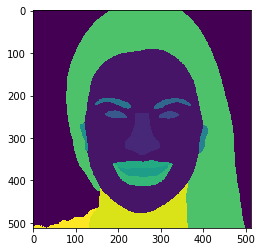

  0%|          | 0/1688 [00:00<?, ?it/s]

---------- best epoch : 2 ----------


 Epoch[20/50] train : runing_Loss 0.07329: 100%|██████████| 1688/1688 [14:24<00:00,  1.95it/s]
 Epoch[20/50] valid : valid_acc 0.16275360182921092 valid_iou 0.7175778746604919: 100%|██████████| 188/188 [00:42<00:00,  4.47it/s]


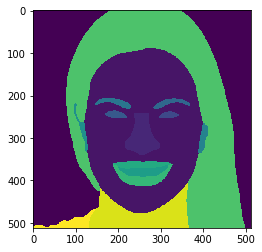

  0%|          | 0/1688 [00:00<?, ?it/s]

---------- best epoch : 2 ----------


 Epoch[21/50] train : runing_Loss 0.07154: 100%|██████████| 1688/1688 [14:24<00:00,  1.95it/s]
 Epoch[21/50] valid : valid_acc 0.17120271440347035 valid_iou 0.7189548015594482: 100%|██████████| 188/188 [00:41<00:00,  4.51it/s]


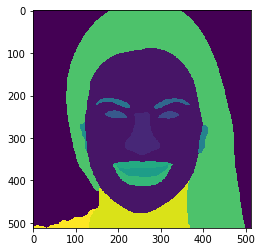

  0%|          | 0/1688 [00:00<?, ?it/s]

---------- best epoch : 2 ----------


 Epoch[22/50] train : runing_Loss 0.07200: 100%|██████████| 1688/1688 [14:25<00:00,  1.95it/s]
 Epoch[22/50] valid : valid_acc 0.1652222491900126 valid_iou 0.7187292575836182: 100%|██████████| 188/188 [00:42<00:00,  4.42it/s] 


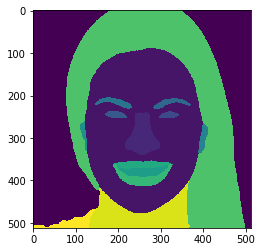

  0%|          | 0/1688 [00:00<?, ?it/s]

---------- best epoch : 2 ----------


 Epoch[23/50] train : runing_Loss 0.06692: 100%|██████████| 1688/1688 [14:25<00:00,  1.95it/s]
 Epoch[23/50] valid : valid_acc 0.17211118976275125 valid_iou 0.718474268913269: 100%|██████████| 188/188 [00:42<00:00,  4.41it/s] 


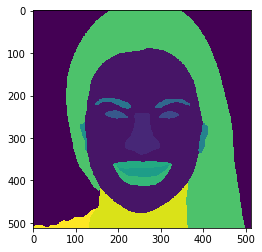

  0%|          | 0/1688 [00:00<?, ?it/s]

---------- best epoch : 2 ----------


 Epoch[24/50] train : runing_Loss 0.06405: 100%|██████████| 1688/1688 [14:25<00:00,  1.95it/s]
 Epoch[24/50] valid : valid_acc 0.17827468832333881 valid_iou 0.718628466129303: 100%|██████████| 188/188 [00:41<00:00,  4.52it/s] 


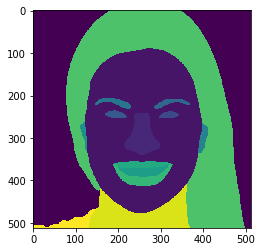

  0%|          | 0/1688 [00:00<?, ?it/s]

---------- best epoch : 2 ----------


 Epoch[25/50] train : runing_Loss 0.06538: 100%|██████████| 1688/1688 [14:25<00:00,  1.95it/s]
 Epoch[25/50] valid : valid_acc 0.1773479481538137 valid_iou 0.7180463075637817: 100%|██████████| 188/188 [00:42<00:00,  4.42it/s] 


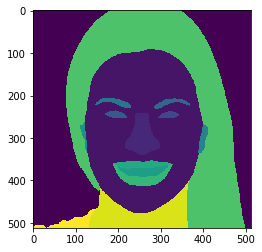

  0%|          | 0/1688 [00:00<?, ?it/s]

---------- best epoch : 2 ----------


 Epoch[26/50] train : runing_Loss 0.06042: 100%|██████████| 1688/1688 [14:25<00:00,  1.95it/s]
 Epoch[26/50] valid : valid_acc 0.18661408444245656 valid_iou 0.7177985906600952: 100%|██████████| 188/188 [00:42<00:00,  4.42it/s]


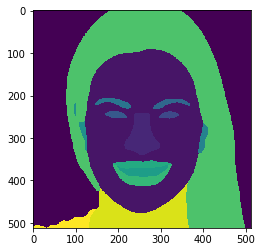

  0%|          | 0/1688 [00:00<?, ?it/s]

---------- best epoch : 2 ----------


 Epoch[27/50] train : runing_Loss 0.05877: 100%|██████████| 1688/1688 [14:25<00:00,  1.95it/s]
 Epoch[27/50] valid : valid_acc 0.18504669137795765 valid_iou 0.7180338501930237: 100%|██████████| 188/188 [00:41<00:00,  4.52it/s]


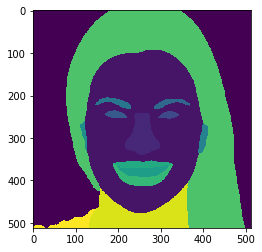

  0%|          | 0/1688 [00:00<?, ?it/s]

---------- best epoch : 2 ----------


 Epoch[28/50] train : runing_Loss 0.06250: 100%|██████████| 1688/1688 [14:24<00:00,  1.95it/s]
 Epoch[28/50] valid : valid_acc 0.18812788724899293 valid_iou 0.7182385325431824: 100%|██████████| 188/188 [00:42<00:00,  4.41it/s]


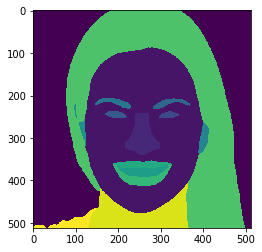

  0%|          | 0/1688 [00:00<?, ?it/s]

---------- best epoch : 2 ----------


 Epoch[29/50] train : runing_Loss 0.05794: 100%|██████████| 1688/1688 [14:24<00:00,  1.95it/s]
 Epoch[29/50] valid : valid_acc 0.19186246073246002 valid_iou 0.717942476272583: 100%|██████████| 188/188 [00:42<00:00,  4.41it/s] 


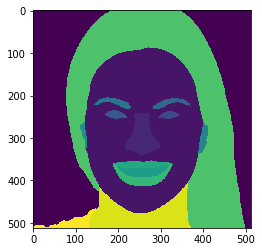

  0%|          | 0/1688 [00:00<?, ?it/s]

---------- best epoch : 2 ----------


 Epoch[30/50] train : runing_Loss 0.05390: 100%|██████████| 1688/1688 [14:25<00:00,  1.95it/s]
 Epoch[30/50] valid : valid_acc 0.19049260091781617 valid_iou 0.7184533476829529: 100%|██████████| 188/188 [00:42<00:00,  4.47it/s]


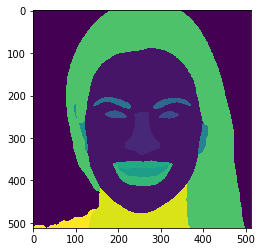

  0%|          | 0/1688 [00:00<?, ?it/s]

---------- best epoch : 2 ----------


 Epoch[31/50] train : runing_Loss 0.05657: 100%|██████████| 1688/1688 [14:24<00:00,  1.95it/s]
 Epoch[31/50] valid : valid_acc 0.19861250392595928 valid_iou 0.7183071970939636: 100%|██████████| 188/188 [00:42<00:00,  4.47it/s]


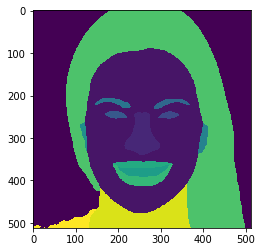

  0%|          | 0/1688 [00:00<?, ?it/s]

---------- best epoch : 2 ----------


 Epoch[32/50] train : runing_Loss 0.05169: 100%|██████████| 1688/1688 [14:25<00:00,  1.95it/s]
 Epoch[32/50] valid : valid_acc 0.20498404717445373 valid_iou 0.7177475690841675: 100%|██████████| 188/188 [00:42<00:00,  4.46it/s]


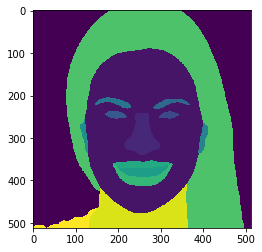

  0%|          | 0/1688 [00:00<?, ?it/s]

---------- best epoch : 2 ----------


 Epoch[33/50] train : runing_Loss 0.05326: 100%|██████████| 1688/1688 [14:25<00:00,  1.95it/s]
 Epoch[33/50] valid : valid_acc 0.19917942309379577 valid_iou 0.7180789113044739: 100%|██████████| 188/188 [00:42<00:00,  4.47it/s]


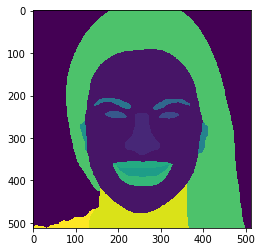

  0%|          | 0/1688 [00:00<?, ?it/s]

---------- best epoch : 2 ----------


 Epoch[34/50] train : runing_Loss 0.04939: 100%|██████████| 1688/1688 [14:25<00:00,  1.95it/s]
 Epoch[34/50] valid : valid_acc 0.2067486526966095 valid_iou 0.7182250022888184: 100%|██████████| 188/188 [00:42<00:00,  4.46it/s] 


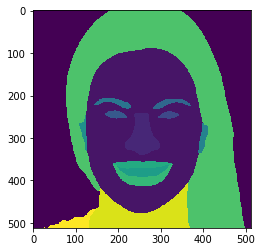

  0%|          | 0/1688 [00:00<?, ?it/s]

---------- best epoch : 2 ----------


 Epoch[35/50] train : runing_Loss 0.05471: 100%|██████████| 1688/1688 [14:25<00:00,  1.95it/s]
 Epoch[35/50] valid : valid_acc 0.19851888008912405 valid_iou 0.7181824445724487: 100%|██████████| 188/188 [00:42<00:00,  4.46it/s]


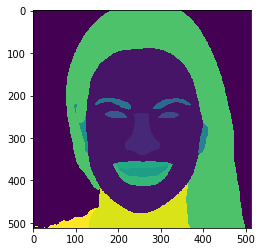

  0%|          | 0/1688 [00:00<?, ?it/s]

---------- best epoch : 2 ----------


 Epoch[36/50] train : runing_Loss 0.05318: 100%|██████████| 1688/1688 [14:24<00:00,  1.95it/s]
 Epoch[36/50] valid : valid_acc 0.19740375785032907 valid_iou 0.718272864818573: 100%|██████████| 188/188 [00:41<00:00,  4.51it/s] 


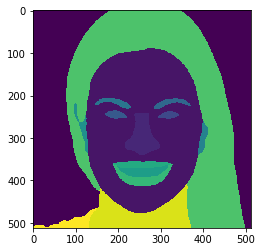

  0%|          | 0/1688 [00:00<?, ?it/s]

---------- best epoch : 2 ----------


 Epoch[37/50] train : runing_Loss 0.04694: 100%|██████████| 1688/1688 [14:25<00:00,  1.95it/s]
 Epoch[37/50] valid : valid_acc 0.2136776932477951 valid_iou 0.7184198498725891: 100%|██████████| 188/188 [00:42<00:00,  4.41it/s] 


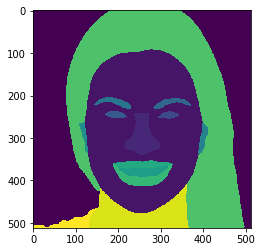

  0%|          | 0/1688 [00:00<?, ?it/s]

---------- best epoch : 2 ----------


 Epoch[38/50] train : runing_Loss 0.04459: 100%|██████████| 1688/1688 [14:25<00:00,  1.95it/s]
 Epoch[38/50] valid : valid_acc 0.22012770875295004 valid_iou 0.7182163000106812: 100%|██████████| 188/188 [00:42<00:00,  4.41it/s]


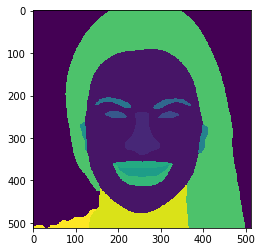

  0%|          | 0/1688 [00:00<?, ?it/s]

---------- best epoch : 2 ----------


 Epoch[39/50] train : runing_Loss 0.04531: 100%|██████████| 1688/1688 [14:25<00:00,  1.95it/s]
 Epoch[39/50] valid : valid_acc 0.21989095588525137 valid_iou 0.718006432056427: 100%|██████████| 188/188 [00:41<00:00,  4.51it/s] 


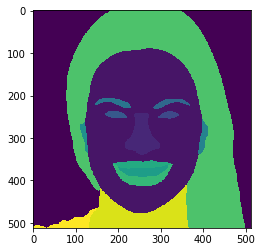

  0%|          | 0/1688 [00:00<?, ?it/s]

---------- best epoch : 2 ----------


 Epoch[40/50] train : runing_Loss 0.05121: 100%|██████████| 1688/1688 [14:25<00:00,  1.95it/s]
 Epoch[40/50] valid : valid_acc 0.20721155540148417 valid_iou 0.7187464237213135: 100%|██████████| 188/188 [00:42<00:00,  4.41it/s]


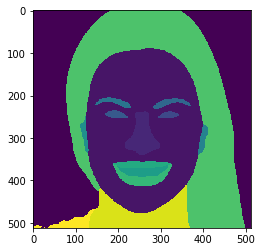

  0%|          | 0/1688 [00:00<?, ?it/s]

---------- best epoch : 2 ----------


 Epoch[41/50] train : runing_Loss 0.04313: 100%|██████████| 1688/1688 [14:25<00:00,  1.95it/s]
 Epoch[41/50] valid : valid_acc 0.22272000428040822 valid_iou 0.7177820801734924: 100%|██████████| 188/188 [00:42<00:00,  4.41it/s]


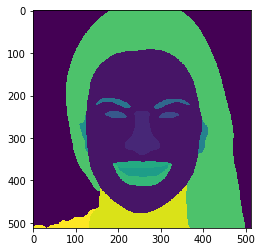

  0%|          | 0/1688 [00:00<?, ?it/s]

---------- best epoch : 2 ----------


 Epoch[42/50] train : runing_Loss 0.04137: 100%|██████████| 1688/1688 [14:25<00:00,  1.95it/s]
 Epoch[42/50] valid : valid_acc 0.2339936598141988 valid_iou 0.7180759906768799: 100%|██████████| 188/188 [00:41<00:00,  4.51it/s] 


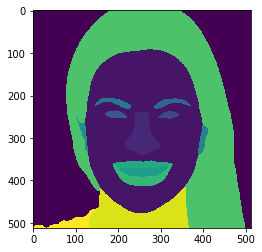

  0%|          | 0/1688 [00:00<?, ?it/s]

---------- best epoch : 2 ----------


 Epoch[43/50] train : runing_Loss 0.04229: 100%|██████████| 1688/1688 [14:25<00:00,  1.95it/s]
 Epoch[43/50] valid : valid_acc 0.22304426697889965 valid_iou 0.7184097170829773: 100%|██████████| 188/188 [00:42<00:00,  4.41it/s]


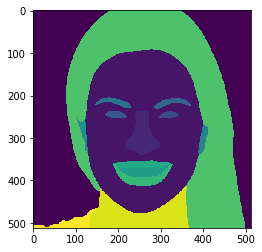

  0%|          | 0/1688 [00:00<?, ?it/s]

---------- best epoch : 2 ----------


 Epoch[44/50] train : runing_Loss 0.04150: 100%|██████████| 1688/1688 [14:25<00:00,  1.95it/s]
 Epoch[44/50] valid : valid_acc 0.21318956851959228 valid_iou 0.7178983688354492: 100%|██████████| 188/188 [00:42<00:00,  4.41it/s]


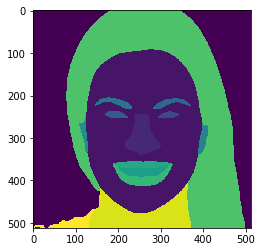

  0%|          | 0/1688 [00:00<?, ?it/s]

---------- best epoch : 2 ----------


 Epoch[45/50] train : runing_Loss 0.04069: 100%|██████████| 1688/1688 [14:25<00:00,  1.95it/s]
 Epoch[45/50] valid : valid_acc 0.23371387362480164 valid_iou 0.7180214524269104: 100%|██████████| 188/188 [00:42<00:00,  4.46it/s]


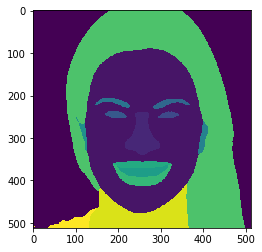

  0%|          | 0/1688 [00:00<?, ?it/s]

---------- best epoch : 2 ----------


 Epoch[46/50] train : runing_Loss 0.03881: 100%|██████████| 1688/1688 [14:25<00:00,  1.95it/s]
 Epoch[46/50] valid : valid_acc 0.2405605285167694 valid_iou 0.7175796031951904: 100%|██████████| 188/188 [00:42<00:00,  4.46it/s] 


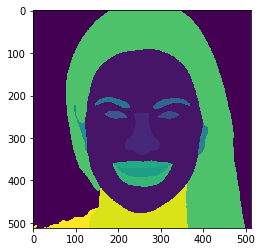

  0%|          | 0/1688 [00:00<?, ?it/s]

---------- best epoch : 2 ----------


 Epoch[47/50] train : runing_Loss 0.04059: 100%|██████████| 1688/1688 [14:25<00:00,  1.95it/s]
 Epoch[47/50] valid : valid_acc 0.2037916359504064 valid_iou 0.718700110912323: 100%|██████████| 188/188 [00:42<00:00,  4.47it/s]  


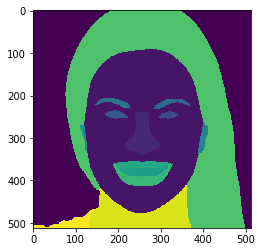

  0%|          | 0/1688 [00:00<?, ?it/s]

---------- best epoch : 2 ----------


 Epoch[48/50] train : runing_Loss 0.04042: 100%|██████████| 1688/1688 [14:24<00:00,  1.95it/s]
 Epoch[48/50] valid : valid_acc 0.2374925235112508 valid_iou 0.7181739211082458: 100%|██████████| 188/188 [00:42<00:00,  4.47it/s] 


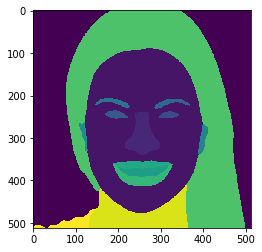

  0%|          | 0/1688 [00:00<?, ?it/s]

---------- best epoch : 2 ----------


 Epoch[49/50] train : runing_Loss 0.03922: 100%|██████████| 1688/1688 [14:25<00:00,  1.95it/s]
 Epoch[49/50] valid : valid_acc 0.22083851889769238 valid_iou 0.7181220054626465: 100%|██████████| 188/188 [00:42<00:00,  4.46it/s]


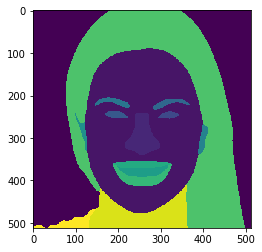

  0%|          | 0/1688 [00:00<?, ?it/s]

---------- best epoch : 2 ----------


 Epoch[50/50] train : runing_Loss 0.03980: 100%|██████████| 1688/1688 [14:25<00:00,  1.95it/s]
 Epoch[50/50] valid : valid_acc 0.238942622145017 valid_iou 0.7181717753410339: 100%|██████████| 188/188 [00:42<00:00,  4.47it/s]  


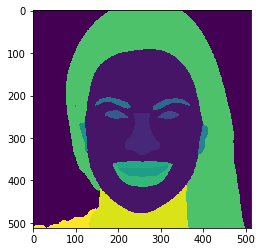

---------- best epoch : 2 ----------


In [20]:
best_model_wts = copy.deepcopy(model.state_dict())
best_iou = 0.0

for epoch in range(num_epochs):
    running_loss = 0.0
    train_corrects = 0
    train_data_cnt = 0
    train_progress_bar = tqdm(train_dataloaders) 
    for inputs, labels in train_progress_bar:
        model.train()
        
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        size = labels.size()
        labels[:, 0, :, :] = labels[:, 0, :, :] * 255.0
        labels_real_plain = labels[:, 0, :, :].cuda()

        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels_real_plain.long())

        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        train_data_cnt += inputs.size(0)
        train_progress_bar.set_description(f" Epoch[{epoch+1}/{num_epochs}] train : runing_Loss {running_loss / train_data_cnt:.5f}")
        
    if scheduler:
        scheduler.step()

    valid_loss = 0
    valid_data_cnt = 0
    val_iou = 0
    valid_progress_bar = tqdm(valid_dataloaders)
    for inputs, labels in valid_progress_bar:    
        model.eval()
        
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        with torch.no_grad ():
            outputs = model(inputs)

        labels_predict_plain = generate_label_plain(outputs)

        intersection = torch.logical_and(labels, torch.tensor(labels_predict_plain).cuda())
        union = torch.logical_or(labels, torch.tensor(labels_predict_plain).cuda())
        val_iou += torch.sum(intersection) / torch.sum(union) * inputs.size(0)

        size = labels.size()
        labels[:, 0, :, :] = labels[:, 0, :, :] * 255.0
        labels_real_plain = labels[:, 0, :, :].cuda()
        loss = criterion(outputs, labels_real_plain.long())
        
        valid_loss += loss.item() * inputs.size(0)
        valid_data_cnt += inputs.size(0)
        valid_progress_bar.set_description(f" Epoch[{epoch+1}/{num_epochs}] valid : valid_acc {valid_loss / valid_data_cnt} valid_iou {val_iou / valid_data_cnt}")
    
    plt.imshow(labels_predict_plain[0])
    plt.show()

    epoch_iou = val_iou / valid_data_cnt
    if epoch_iou > best_iou:
        best_iou = epoch_iou
        best_epoch = epoch
        best_model_wts = copy.deepcopy(model.state_dict())
    print('-'*10, f"best epoch : {best_epoch}", '-'*10)